In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import albumentations as A
from functools import partial
import tensorflow_datasets as tfds
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0


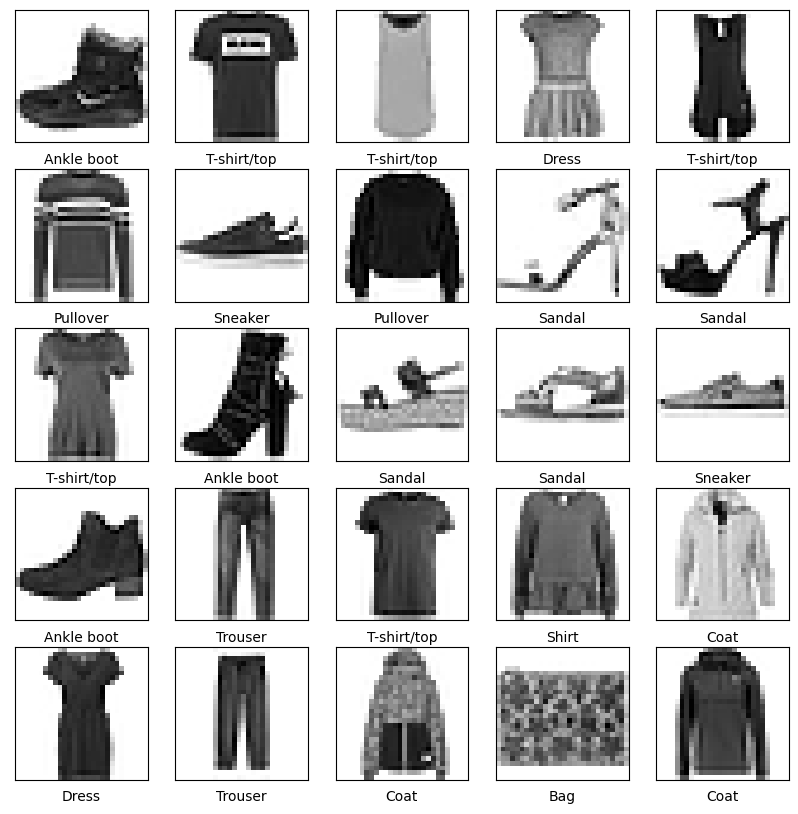

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_images, train_labels, test_size=0.1, random_state=10, stratify=train_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
def exponential_decay_fn(epoch, current_lr):
  return current_lr * 0.2**(epoch / 10)

In [9]:
adam_optim = tf.keras.optimizers.Adam(learning_rate=0.001, decay=exponential_decay_fn(30, 0.001))

In [10]:
model.compile(optimizer=adam_optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
EPOCHS = 30
checkpoint_filepath = './tmp2/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
train_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=128, callbacks=[model_checkpoint_callback])

#!mkdir -p saved_model
#model.save('saved_model/my_model')


Epoch 1/30
338/338 [==============================] - 3s 8ms/step - loss: 0.5516 - accuracy: 0.8072 - val_loss: 0.4030 - val_accuracy: 0.8584
Epoch 2/30
338/338 [==============================] - 2s 6ms/step - loss: 0.3925 - accuracy: 0.8587 - val_loss: 0.4182 - val_accuracy: 0.8461
Epoch 3/30
338/338 [==============================] - 2s 7ms/step - loss: 0.3481 - accuracy: 0.8736 - val_loss: 0.3800 - val_accuracy: 0.8632
Epoch 4/30
338/338 [==============================] - 3s 8ms/step - loss: 0.3169 - accuracy: 0.8830 - val_loss: 0.3111 - val_accuracy: 0.8866
Epoch 5/30
338/338 [==============================] - 3s 10ms/step - loss: 0.3013 - accuracy: 0.8880 - val_loss: 0.3152 - val_accuracy: 0.8842
Epoch 6/30
338/338 [==============================] - 4s 12ms/step - loss: 0.2858 - accuracy: 0.8942 - val_loss: 0.3148 - val_accuracy: 0.8881
Epoch 7/30
338/338 [==============================] - 3s 9ms/step - loss: 0.2687 - accuracy: 0.9001 - val_loss: 0.2983 - val_accuracy: 0.8937
Epoc

In [13]:
os.listdir(checkpoint_filepath)

['.data-00000-of-00001', '.index', 'checkpoint']

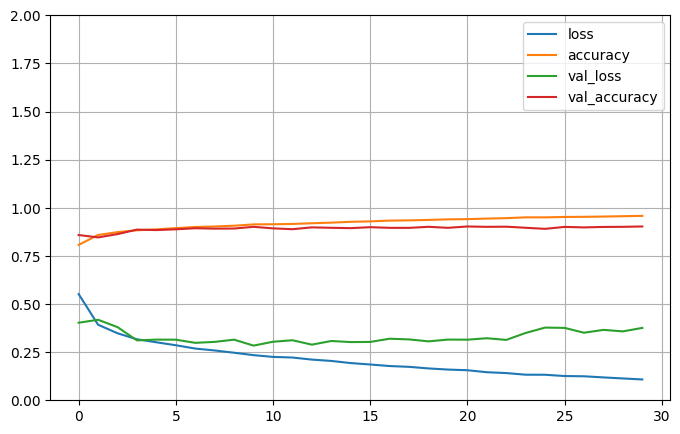

In [14]:
pd.DataFrame(train_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [15]:
model.load_weights(checkpoint_filepath)

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

188/188 - 0s - loss: 0.3195 - accuracy: 0.8998 - 458ms/epoch - 2ms/step

Test accuracy: 0.8998333215713501


In [17]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [18]:
def weryfikacja(nr):
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(nr, predictions[nr], y_test, X_test)
    plt.subplot(1,2,2)
    plot_value_array(nr, predictions[nr],  y_test)
    plt.show()


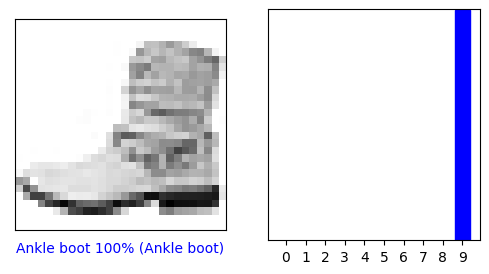

In [19]:
weryfikacja(3)

# Rozwiązanie z augmentacją

In [65]:
data, info= tfds.load(name="fashion_mnist", split=["train", 'test[:20%]'], as_supervised=True, with_info=True)
data


[<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [66]:
train_data=data[0]
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [67]:
test_data=data[1]
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [68]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label


In [69]:
ds_train_tf = train_data.map(partial(process_image, img_size=28), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_train_tf


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [70]:
ds_test_tf = test_data.map(partial(process_image, img_size=28), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_test_tf


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

In [38]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [39]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [71]:
ds_train_alb = train_data.map(partial(process_data, img_size=28),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_train_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [72]:
ds_test_alb = test_data.map(partial(process_data, img_size=28),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_test_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [73]:
def set_shapes(img, label, img_shape=(28,28,1)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label


In [74]:
ds_train_alb = ds_train_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_train_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [75]:
ds_test_alb = ds_test_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_test_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [76]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [77]:
model2.compile(optimizer=adam_optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [89]:
train_history2 = model2.fit(ds_train_alb, epochs=10, batch_size=512)

Epoch 1/10
1875/1875 [==============================] - 93s 49ms/step - loss: 0.4020 - accuracy: 0.8523
Epoch 2/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.3933 - accuracy: 0.8555
Epoch 3/10
1875/1875 [==============================] - 154s 82ms/step - loss: 0.3820 - accuracy: 0.8584
Epoch 4/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.3767 - accuracy: 0.8597
Epoch 5/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.3703 - accuracy: 0.8620
Epoch 6/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.3618 - accuracy: 0.8653
Epoch 7/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.3599 - accuracy: 0.8661
Epoch 8/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.3519 - accuracy: 0.8688
Epoch 9/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.3459 - accuracy: 0.8704
Epoch 10/10
1875/1875 [==============================] - 86

In [90]:
model2.evaluate(ds_test_alb, verbose=2)

63/63 - 1s - loss: 0.3983 - accuracy: 0.8575 - 1s/epoch - 22ms/step


[0.3983028531074524, 0.8575000166893005]